## Семинар 1 "Полносвязные нейронные сети"

ФИО: Салихова Кария Илшатовна

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400/>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

Важным требованием к реализации является векторизация всех слоев: все операции должны быть сведены к матричным, не должно быть циклов. Это значительно уменьшает временные затраты.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Часть 1: Линейный слой


Приведем пример вычисления градиентов для линейного слоя: $y = Wx$, $x \in \mathbb{R}^{K \times n}$, $y \in \mathbb{R}^{K \times n}$, $W \in \mathbb{R}^{n \times m}$, где $K$ — число объектов.

Рассмотрим $L$ как функцию от выходов нейронной сети: $L = L(y_{11}, y_{12}, \dots)$

$$y_{kt} = (Wx)_{kt} = \sum_{z=1}^{n} x_{kz}W_{zt}$$

$$\frac{\partial L}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial y_{kt}}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial \sum_z x_{kz}w_{zt}}{\partial x_{ij}}= \sum_{t} \frac{\partial L}{\partial y_{it}}\frac{\partial w_{jt}}{\partial x_{ij}}$$

$$\frac{\partial{L}}{\partial x} = \frac{\partial{L}}{\partial y}W^T$$

In [2]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        self.W = np.random.randn(input_size, output_size) * 0.1
        self.b = np.zeros(output_size)
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X @ self.W + self.b
    
    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        #y = X*W+b
        #dL/db = dL/dy * dy/db = dL/dy
        #dL/dW = dL/dy * dy/dw = dL/dy * X
        #dL/dx = dL/dy * dy/dx = dL/dy * W
        self.dLdW = self.X.T @ dLdy
        self.dLdb = np.sum(dLdy, axis=0)
        dLdx = dLdy @ self.W.T
        return dLdx
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        self.W -= learning_rate * self.dLdW
        self.b -= learning_rate * self.dLdb

### Часть 2: Численный градиент

Релизуйте функцию проверки численного градиента. Для этого для каждой переменной, по которой считается градиент, надо вычислить численный градиент: $f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Функция должна возвращать максимальное абсолютное отклонение аналитического градиента от численного. В качестве $\epsilon$ рекомендуется взять $10^{-6}$. При правильной реализации максимальное отличие будет иметь порядок $10^{-8}-10^{-6}$.

In [3]:
def check_gradient(func, X, gradient):
    '''
    Computes numerical gradient and compares it with analytcal.
    func: callable, function of which gradient we are interested. Example call: func(X)
    X: np.array of size (n x m)
    gradient: np.array of size (n x m)
    Returns: maximum absolute diviation between numerical gradient and analytical.
    '''
    eps = 10**(-8)
    ngrad_full = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i, j] += eps
            f_right = func(X)
            X[i, j] -= 2*eps
            f_left = func(X)
            X[i, j] += eps
            ngrad_full[i, j] = (f_right - f_left)/(2*eps)
    return np.max(np.abs(ngrad_full - gradient))

In [4]:
np.random.seed(777)
x = np.random.rand(10, 20)
func = lambda x: (x**2).sum()
gradient = 2*x
check_gradient(func, x, gradient)

5.681270753843393e-07

Протестируйте линейный слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$ и $\frac{\partial L}{\partial w}$.

In [5]:
np.random.seed(0)
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([[0], [1], [1], [1]])
l = Linear(2, 1)

def loss(W):
    l.W = W
    res = l.forward(X)
    return np.sum((res - Y)**2)

res = l.forward(X)
print(res)
dLdy = 2*(res - Y)
print(dLdy)
dLdx = l.backward(dLdy)
print(dLdx)
print(l.dLdW)

check_gradient(loss, l.W, l.dLdW)

[[0.        ]
 [0.04001572]
 [0.17640523]
 [0.21642096]]
[[ 0.        ]
 [-1.91996856]
 [-1.64718953]
 [-1.56715809]]
[[ 0.          0.        ]
 [-0.3386925  -0.07682893]
 [-0.29057286 -0.06591348]
 [-0.27645489 -0.06271096]]
[[-3.21434762]
 [-3.48712665]]


2.8845219102180408e-08

### Часть 3: Сигмоида

In [6]:
class Sigmoid:
    def __init__(self):
        pass
    
    def sigm(self, X):
        return 1 / (1 + np.exp(-X))
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        self.y = self.sigm(X)
        return self.y
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        #y = 1 /(1 + exp(-x))
        #dL/dx = dL/dy * dy/dx
        #dy/dx = sigm(X)*(1-sigm(X))
        dLdx = dLdy * self.y * (1 - self.y)
        return dLdx
    
    def step(self, learning_rate):
        pass

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [7]:
np.random.seed(0)
X = np.array([[0.1, 0.2, 0.3, 0.2], [0.1, 0.1, 0.2, 0], [0.2, 0, 0.3, 0.5]])
s = Sigmoid()

def loss_s(X):
    res = s.forward(X)
    return np.sum(res**2)

res = s.forward(X)
print(res)
dLdy = 2*res
print(dLdy)
dLdx = s.backward(dLdy)
print(dLdx)
check_gradient(loss_s, X, dLdx)

[[0.52497919 0.549834   0.57444252 0.549834  ]
 [0.52497919 0.52497919 0.549834   0.5       ]
 [0.549834   0.5        0.57444252 0.62245933]]
[[1.04995837 1.09966799 1.14888503 1.09966799]
 [1.04995837 1.04995837 1.09966799 1.        ]
 [1.09966799 1.         1.14888503 1.24491866]]
[[0.26183446 0.27218605 0.2808545  0.27218605]
 [0.26183446 0.26183446 0.27218605 0.25      ]
 [0.27218605 0.25       0.2808545  0.29256051]]


2.387956649085865e-08

### Часть 4: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://blog.feedly.com/tricks-of-the-trade-logsumexp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [8]:
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        #### YOUR CODE HERE
        #### (Hint: No code is expected here, just joking)
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.X = X
        self.y = y
        y_max = np.max(X, axis=1)
        y_max = np.resize(y_max, X.T.shape).T
        self.P = X - y_max - np.resize(np.log(np.sum(np.exp(X - y_max), axis=1)), X.T.shape).T
        #классы с нуля
        self.loss = np.mean(-self.P[range(X.shape[0]), y])
        return self.loss
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        e = np.exp(self.X)
        p = e / np.sum(e, axis=1, keepdims=True)
        mask = np.zeros_like(p)
        mask[range(self.X.shape[0]), self.y] = 1
        return (1 / self.X.shape[0])*(p - mask)

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [9]:
def check_gradient1(func, X, y, gradient):
    '''
    Computes numerical gradient and compares it with analytcal.
    func: callable, function of which gradient we are interested. Example call: func(X)
    X: np.array of size (n x m)
    gradient: np.array of size (n x m)
    Returns: maximum absolute diviation between numerical gradient and analytical.
    '''
    eps = 10**(-6)
    ngrad_full = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i, j] += eps
            f_right = func(X, y)
            X[i, j] -= 2*eps
            f_left = func(X, y)
            X[i, j] += eps
            ngrad_full[i, j] = (f_right - f_left)/(2*eps)
    print(ngrad_full)
    return np.max(np.abs(ngrad_full - gradient))

In [10]:
np.random.seed(0)
X = np.array([[0, 0.2], [0.1, 0.4], [0.2, 0.7]])
y = np.array([0, 1, 1])
n = NLLLoss()

def loss(X, y):
    res = n.forward(X, y)
    return res

res = n.forward(X, y)
print(res)

dLdx = n.backward()
print(dLdx)
check_gradient1(loss, X, y, dLdx)

0.6088570326767418
[[-0.183278    0.183278  ]
 [ 0.14185249 -0.14185249]
 [ 0.12584689 -0.12584689]]
[[-0.183278    0.183278  ]
 [ 0.14185249 -0.14185249]
 [ 0.12584689 -0.12584689]]


6.201666957750263e-11

### Часть 5, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [11]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules
    
    def forward(self, X):
        new_X = X
        for module in self.modules:
            new_X = module.forward(new_X)
        return new_X
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        new_dLdy = dLdy
        for module in self.modules[::-1]:
            new_dLdy = module.backward(new_dLdy)
    
    def step(self, learning_rate):
        for module in self.modules:
            module.step(learning_rate)

### Часть 6, обучение на простых данных

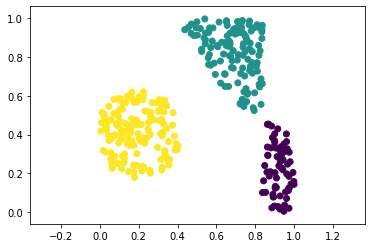

In [12]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.005). 
2. Нарисуйте график сходимости (величина NLL после каждого обновления).
3. Нарисуйте разделяющую поверхность
4. Попробуйте подобрать темп обучения. Как меняется сходимость?

Отличная визуализация: http://playground.tensorflow.org/

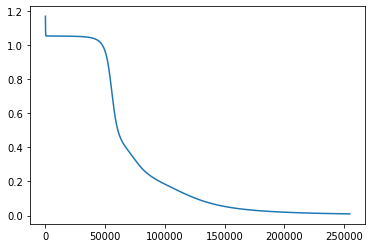

In [13]:
network1 = NeuralNetwork([Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)])
learning_rate = 0.005
eps = 10**(-2)
loss = NLLLoss()
losses = []
new_X = network1.forward(X)
l = loss.forward(new_X, y)
while l > eps:
    dLdy = loss.backward()
    network1.backward(dLdy)
    network1.step(learning_rate)
    new_X = network1.forward(X)
    l = loss.forward(new_X, y)
    losses.append(l)
res = np.argmax(new_X, axis=1)
plt.plot(np.array(losses))

In [14]:
num = 60
x_values = np.linspace(-0.2, 1.2, num)
y_values = np.linspace(-0.2, 1.2, num)
xx, yy = np.meshgrid(x_values, y_values)
x_grid = np.concatenate([xx.reshape((num*num, 1)), yy.reshape((num*num, 1))], axis=1)
new_x_grid = network1.forward(x_grid)
res1 = np.argmax(new_x_grid, axis=1)

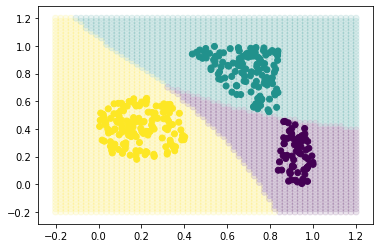

In [15]:
plt.scatter(x_grid[:, 0], x_grid[:, 1], c=res1, alpha=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

## Домашнее задание:

* Подоберите темп обучения. Как меняется сходимость? Нарисуйте график оптимального значения функции потерь для различных значений learning_rate
* Решите поставленную выше задачу как задачу регрессии с MSE. Изменилась ли разделяющая поверхность?

The best learning_rate:  0.6899655172413793


Text(0, 0.5, 'Loss')

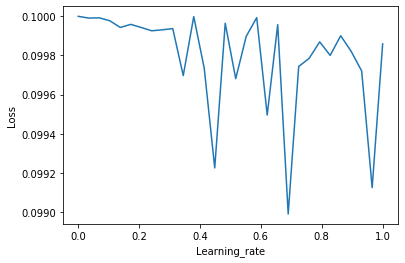

In [16]:
learning_rate_mass = np.linspace(0.001, 1, num=30)
eps = 10**(-1)
all_losses = []
for rate in learning_rate_mass:
    network = NeuralNetwork([Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)])
    loss = NLLLoss()
    losses = []
    new_X = network.forward(X)
    l = loss.forward(new_X, y)
    while l > eps:
        dLdy = loss.backward()
        network.backward(dLdy)
        network.step(rate)
        new_X = network.forward(X)
        l = loss.forward(new_X, y)
    all_losses.append(l)
print('The best learning_rate: ',learning_rate_mass[np.argmin(all_losses)])
plt.plot(learning_rate_mass, all_losses)
plt.xlabel('Learning_rate')
plt.ylabel('Loss')

In [18]:
def loss(res, y):
    return np.sum((res - y)**2) / res.shape[0]

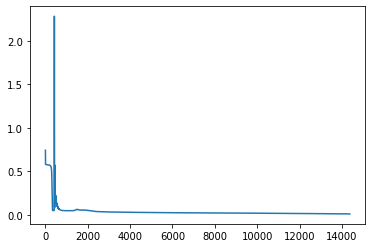

In [25]:
network2 = NeuralNetwork([Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 1)])
learning_rate = 0.69
eps = 10**(-2)
losses = []
new_X = network2.forward(X)
y_copy = np.resize(y, new_X.T.shape).T
l = loss(new_X, y_copy)
while l > eps:
    dLdy = 2*(new_X - y_copy) / new_X.shape[0]
    network2.backward(dLdy)
    network2.step(learning_rate)
    new_X = network2.forward(X)
    l = loss(new_X, y_copy)
    losses.append(l)
plt.plot(np.array(losses)[4:-1:1])

In [26]:
res1 = np.round(new_X.T[0]).astype(int)

In [30]:
num = 60
x_values = np.linspace(-0.2, 1.2, num)
y_values = np.linspace(-0.2, 1.2, num)
xx, yy = np.meshgrid(x_values, y_values)
x_grid = np.concatenate([xx.reshape((num*num, 1)), yy.reshape((num*num, 1))], axis=1)
new_x_grid = network2.forward(x_grid)
res2 = np.round(new_x_grid.T[0]).astype(int)
res2[res2 == 3] = 2

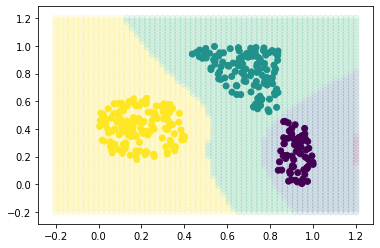

In [31]:
plt.scatter(x_grid[:, 0], x_grid[:, 1], c=res2, alpha=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()